In [1]:
import csv
import importlib
import itertools
import operator
import os
import random
import time
from math import e, exp, log, pi, sqrt
import os
import psutil

import keras.layers as layers
import copy
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from numba import guvectorize, jit, njit, prange, vectorize
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import tensorflow as tf
from os.path import *
import glob
import cnn_builder as cbuild
import cnn_runner as crun
import config
import dr_methods as drm
import feature_interpretation as cnna
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import niftiutils.visualization as vis
import voi_methods as vm
import feature_influence as finf
import niftiutils.deep_learning.common as common
import math
import tensorflow as tf
from keras import backend as K
c = tf.ConfigProto()
c.gpu_options.allow_growth=True
sess = tf.Session(config=c)
K.set_session(sess)

%matplotlib inline
np.set_printoptions(3)

Using TensorFlow backend.


In [2]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
importlib.reload(cnna)
importlib.reload(crun)
C = config.Config()
T = config.Hyperparams(C.dataset)

In [ ]:
R.pred_model.summary()

In [ ]:
R = crun.CNNRunner(C,T)
R.run_fixed_hyperparams(max_runs=2, Z_test=C.Z_reader, model_name='fixZ_std_', verbose=True)

### KDE for feature identification

In [ ]:
importlib.reload(cnna)
full_dfs = cnna.feature_id_bulk(range(10,20))

In [3]:
Z_test = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

In [4]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()
num_annotations = 10

features_by_cls, feat_count = cnna.collect_features()
feat_count.pop("homogeneous texture")
all_features = sorted(list(feat_count.keys()))
cls_features = {f: [c for c in C.cls_names if f in features_by_cls[c]] for f in all_features}

Z_features = cnna.get_annotated_files(features_by_cls, num_annotations)
Z_features.pop("homogeneous texture")

num_features = len(all_features) # number of features

all_imgs = [orig_data_dict[cls][0] for cls in C.cls_names]
all_imgs = np.array(hf.flatten(all_imgs))

all_lesionids = [orig_data_dict[cls][1] for cls in C.cls_names]
all_lesionids = np.array(hf.flatten(all_lesionids))
test_indices = np.where(np.isin(all_lesionids, C.Z_reader))[0]

x_test = all_imgs[test_indices]
z_test = all_lesionids[test_indices]

full_dfs = []

train_indices = np.where(~np.isin(all_lesionids, C.Z_reader))[0]
z_train = all_lesionids[train_indices]
x_train = all_imgs[train_indices]

In [7]:
model_prefix = 'fixZ_std_'
model_ix = 0

In [8]:
features_cls_dict = {f:[cls for cls in C.cls_names if f in features_by_cls[cls]] for f in all_features}

In [9]:
z_train_cls = {cls:orig_data_dict[cls][1] for cls in C.cls_names}

In [10]:
excl_features = {f:[] for f in all_features}
for f in all_features:
    for g in all_features:
        if len(set(features_cls_dict[g]).intersection(features_cls_dict[f])) == 0:
            excl_features[f].append(g)

fullM = keras.models.load_model(join(C.model_dir, model_prefix+"%d.hdf5" % model_ix))
M = keras.models.load_model(join(C.model_dir, model_prefix+"%d.hdf5" % model_ix))
M = common.pop_n_layers(M, 3)

all_dense = cnna.get_overall_activations(M, orig_data_dict)
feature_dense = cnna.get_feature_activations(M, Z_features, all_features)

In [29]:
import shutil
shutil.rmtree("/data/vision/polina/users/clintonw/code/voi-classifier/imgs/aug_imgs/aug_imgs")

In [79]:
len(glob.glob("/data/vision/polina/users/clintonw/code/voi-classifier/imgs/unaug_imgs/E100718398_0*"))

['/data/vision/polina/users/clintonw/code/voi-classifier/imgs/unaug_imgs/E100718398_0.npy']

In [8]:
importlib.reload(cnna)
fullM = keras.models.load_model(join(C.model_dir, model_prefix+"%d.hdf5" % model_ix))
model_fc = keras.models.load_model(join(C.model_dir, model_prefix+"%d.hdf5" % model_ix))
model_fc = common.pop_n_layers(model_fc, 3)
model_conv = keras.models.load_model(join(C.model_dir, model_prefix+"%d.hdf5" % model_ix))
model_conv = common.pop_n_layers(model_conv, 9)

In [11]:
all_dense = cnna.get_overall_activations(z_train_cls, model_fc, samples=500)

In [10]:
feature_dense = cnna.get_feature_activations(Z_features, all_features, model_fc)

In [ ]:
shutil.copy("/data/vision/polina/users/clintonw/code/voi-classifier/imgs/aug_imgs/E102284920_0_2.npy", "/data/vision/polina/users/clintonw/code/voi-classifier/imgs/aug_imgs/E102284920_0_1.npy")

In [15]:
train_df = cnna.predict_test_features(fullM, model_fc, all_dense, feature_dense, x_train, z_train, Z_features=Z_features, num_samples=2)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [16]:
importlib.reload(cnna)
test_df = cnna.predict_test_features(fullM, model_fc, all_dense, feature_dense, x_test, z_test, num_samples=30)

............................................................

In [17]:
hf.pickle_dump(train_df, join(C.model_dir, "train_df_%d.bin" % model_ix))
hf.pickle_dump(test_df, join(C.model_dir, "test_df_%d.bin" % model_ix))

In [359]:
train_df = hf.pickle_load(join(C.model_dir, "train_df_%d.bin" % model_ix))
test_df = hf.pickle_load(join(C.model_dir, "test_df_%d.bin" % model_ix))

In [18]:
priors = {f:0 for f in all_features}
thresh = {f:0 for f in all_features}
for f in all_features:
    priors[f] = np.max(train_df.loc[:, f].values)
    thresh[f] = np.min(train_df.loc[Z_features[f], f].values)

priors = {f:0 for f in all_features}
for cls in C.cls_names:
    for f in all_features:
        priors[f] += np.mean(np.log(train_df.loc[train_df["true_cls"] == cls, f].values))
        
for f in all_features:
    priors[f] = priors[f] / 6

for f in all_features:
    priors[f] = np.max(np.log(test_df[f].values))

In [ ]:
for f in all_features:
    print(f, thresh[f]/priors[f])

In [19]:
df = copy.deepcopy(test_df)
for l_id in df.index:
    for f in all_features:
        df.loc[l_id, f] = df.loc[l_id, f] / priors[f] if df.loc[l_id, f] > thresh[f] else 0

In [20]:
arank = df.drop(['true_cls','pred_cls'], axis=1).apply(np.argsort, axis=1)
ranked_cols = df.columns[2:].to_series()[arank.values[:,::-1]]
new_df = pd.DataFrame(ranked_cols, index=df.index)

In [21]:
pred_f_cols = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
for ix,col in enumerate(pred_f_cols):
    df[col] = new_df[ix].values

In [25]:
for lesion_id, row in df.iterrows(): #exclude incompatible features
    for col in pred_f_cols[1:]:
        f = row[col]
        #exc = sum([row[g]>0 for g in excl_features[f]])
        if row[f] == 0:# or row['feature_1'] in excl_features[f]:#exc >= 1:
            df.loc[lesion_id, f] = 0
            df.loc[lesion_id, col] = np.nan

arank = df.drop(['true_cls','pred_cls'] + pred_f_cols, axis=1).apply(np.argsort, axis=1)
ranked_cols = df.columns[2:].to_series()[arank.values[:,::-1]]
new_df = pd.DataFrame(ranked_cols, index=df.index)
pred_f_cols = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
for ix,col in enumerate(pred_f_cols):
    df[col] = new_df[ix].values
for lesion_id, row in df.iterrows():
    for col in pred_f_cols[1:]:
        f = row[col]
        if row[f] == 0:
            df.loc[lesion_id, col] = np.nan

In [35]:
hf.pickle_dump(df, join(C.model_dir, "df_%d.bin" % model_ix))

In [67]:
model_ix = 1
df = hf.pickle_load(join(C.model_dir, "df_%d.bin" % model_ix))

In [5]:
prefix = ""#"noaug_"
full_dfs = [hf.pickle_load(join(C.model_dir, prefix+"df_%d.bin" % ix)) for ix in range(20)]

In [6]:
data_dir = join(C.base_dir, 'excel')
answer_key = join(data_dir, "ground_truth.xlsx")
answer_key = pd.read_excel(answer_key, index_col=0)

In [7]:
miscls_accnums = [[accnum for accnum in answer_key.index if df.loc[accnum, 'true_cls'] != df.loc[accnum, 'pred_cls']] \
                  for df in full_dfs]

In [26]:
importlib.reload(cnna)
feat_df, cls_df, MISCLS, prec_history, recall_history, perfect, miscls_accnums = cnna.process_feat_id_dfs(all_features, full_dfs, class_condition=False)

In [27]:
hf.pickle_dump(prec_history, join(C.model_dir, prefix+"prec_history.bin"))
hf.pickle_dump(recall_history, join(C.model_dir, prefix+"recall_history.bin"))

In [30]:
np.mean(prec_history["total"]), np.mean(recall_history["total"])

(0.7757635402501387, 0.712012987012987)

In [29]:
(feat_df["num_correct"]/feat_df["pred_freq"]).mean()

0.7700850378851273

In [ ]:
[print(" & ".join([f,
   str(int(feat_df.loc[f, "true_freq"]/20)),
   "%.1f $\pm$ %.1f\%%"%(100*np.mean(prec_history[f]),
                      100*np.std(prec_history[f])),
   "%.1f $\pm$ %.1f\%%"%(100*np.mean(recall_history[f]),
                      100*np.std(recall_history[f])),
                  ])) for f in all_features];

In [11]:
import seaborn as sns

In [55]:
X = []
for f in all_features:
    for i in range(20):
        X.append([i, f, prec_history[f][i], recall_history[f][i]])

In [56]:
df = pd.DataFrame(X, columns=["run number", "feature", "precision", "recall"])

In [68]:
melt_df = df.melt(id_vars=["run number", "feature"], value_vars=["precision", "recall"], var_name="metric")

In [100]:
for ix, row in df.iterrows():
    df.loc[ix, "precision_mean"] = df.loc[df.feature == df.loc[ix, "feature"], "precision"].mean()

In [101]:
df = df.sort_values("precision_mean")

In [ ]:
for i,x in enumerate(sorted(all_features, key=lambda f: np.mean(prec_history[f]))):
    print(str(i+1) + ": " + x)

In [32]:
prefix = "noaug_"
prec_history = hf.pickle_load(join(C.model_dir, prefix+"prec_history.bin"))
recall_history = hf.pickle_load(join(C.model_dir, prefix+"recall_history.bin"))

In [33]:
X_tot = []
for i in range(20):
    X_tot.append([i, prec_history["total"][i], recall_history["total"][i]])
df_total = pd.DataFrame(X_tot, columns=["run number", "precision", "recall"])
df_total = df_total.melt(id_vars=["run number"], value_vars=["precision", "recall"], var_name="metric")

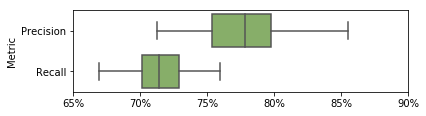

In [34]:
plt.figure(figsize=(6,1.5))
ax = sns.boxplot(x="value", y="metric", color='#86b95e', data=df_total)
#ax = sns.boxplot(x="feature", y="value", hue="metric", data=melt_df)
ax.set(xlim=[.65,.9])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
ax.set(xlabel='', ylabel='Metric');
ax.set_yticklabels(['Precision', 'Recall']);
plt.savefig("/data/vision/polina/users/clintonw/overall_noaug.png", dpi=800, bbox_inches="tight", pad_inches=0)

In [ ]:
plt.figure(figsize=(10,4))
ax = sns.boxplot(x="feature", y="precision", color='#86b95e', data=df)
#ax = sns.boxplot(x="feature", y="value", hue="metric", data=melt_df)
ax.set(xlabel='Features', xticks=[], ylabel='Precision');#, xticklabels=range(1,15));

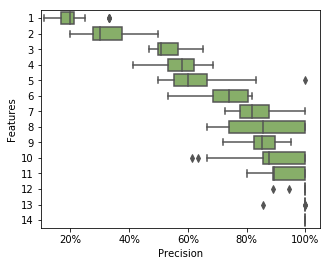

In [166]:
plt.figure(figsize=(5,4))
ax = sns.boxplot(y="feature", x="precision", color='#86b95e', data=df)
ax.set(xlim=[0.1,1.05])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
#ax = sns.boxplot(x="feature", y="value", hue="metric", data=melt_df)
ax.set(ylabel='Features', yticklabels=range(1,15), xlabel='Precision');
plt.savefig("/data/vision/polina/users/clintonw/precision.png", dpi=800, bbox_inches="tight", pad_inches=0)

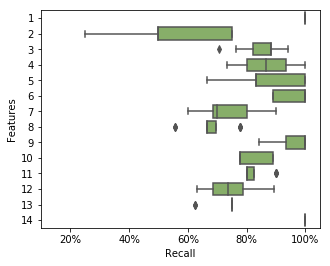

In [170]:
plt.figure(figsize=(5,4))
ax = sns.boxplot(y="feature", x="recall", color='#86b95e', data=df) #5689ee
#ax = sns.boxplot(x="feature", y="value", hue="metric", data=melt_df)
ax.set(xlim=[0.1,1.05]);
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
ax.set(ylabel='Features', yticklabels=range(1,15), xlabel='Recall');
plt.savefig("/data/vision/polina/users/clintonw/recall.png", dpi=800, bbox_inches="tight", pad_inches=0)

In [173]:
exclusive_pairs = []
for i in range(num_features-1):
    f = all_features[i]
    for j in range(i,num_features):
        g = all_features[j]
        if not np.any([f in features_by_cls[cls] and g in features_by_cls[cls] for cls in C.cls_names]):
            exclusive_pairs.append((f,g))

predictions = {key:(df.loc[key][['feature_1', 'feature_2', 'feature_3', 'feature_4']].dropna().values, df.loc[key, 'pred_cls']) for key in df.index}

incompatible_accnums = []
for accnum, preds in predictions.items():
    feats, pred_cls = preds
    if len([f for f in feats if f not in features_by_cls[pred_cls]]) > 0:
        incompatible_accnums.append(accnum)

In [ ]:
for ix, df in enumerate(full_dfs):
    miscls_acc_i = miscls_accnums[ix]
    key = "E101415263_0"
    predictions = (df.loc[key][['feature_1', 'feature_2', 'feature_3', 'feature_4']].dropna().values, df.loc[key, 'pred_cls'])
    print(predictions)

In [208]:
answer_features = {key:row[['feature_1', 'feature_2', 'feature_3', 'feature_4']].dropna().values for key, row in answer_key.iterrows()}
ignore_features = {key:row[['ignore_1', 'ignore_2']].dropna().values for key, row in answer_key.iterrows()}
A=[]
for ix, df in enumerate(full_dfs):
    miscls_acc_i = miscls_accnums[ix]
    predictions = {key:(df.loc[key][['feature_1', 'feature_2', 'feature_3', 'feature_4']].dropna().values, df.loc[key, 'pred_cls']) for key in df.index}
    
    incompatible_accnums, perfect_accnums = [], []
    for accnum, preds in predictions.items():
        pred_feats, pred_cls = preds
        if len([f for f in pred_feats if f not in features_by_cls[pred_cls]]) > 0:
            incompatible_accnums.append(accnum)
        if len(set([f for f in pred_feats if f not in ignore_features[accnum]]).difference([f \
            for f in answer_features[accnum] if f in pred_feats])) == 0:
            perfect_accnums.append(accnum)
    miscls_incomp_accnums = set(miscls_acc_i).intersection(incompatible_accnums)
    miscls_perfect_accnums = set(miscls_acc_i).intersection(perfect_accnums)
    miscls_uhoh_accnums = set(miscls_acc_i).intersection(perfect_accnums).difference(incompatible_accnums)
    
    print("miscls_incomp", len(miscls_incomp_accnums),
          "all incompatible", len(incompatible_accnums),
          "all misclass", len(miscls_acc_i),
          "misclass perfect", len(miscls_perfect_accnums),
          "misclass perf+compat", len(miscls_uhoh_accnums),
          "all perfect", len(perfect_accnums))
       
    A.append((len(miscls_incomp_accnums),len(incompatible_accnums),len(miscls_acc_i),
             len(miscls_perfect_accnums),len(miscls_uhoh_accnums),len(perfect_accnums)))

miscls_incomp 6 all incompatible 37 all misclass 7 misclass perfect 2 misclass perf+compat 0 all perfect 18
miscls_incomp 7 all incompatible 25 all misclass 8 misclass perfect 1 misclass perf+compat 0 all perfect 26
miscls_incomp 4 all incompatible 26 all misclass 6 misclass perfect 0 misclass perf+compat 0 all perfect 25
miscls_incomp 6 all incompatible 29 all misclass 8 misclass perfect 1 misclass perf+compat 0 all perfect 23
miscls_incomp 6 all incompatible 36 all misclass 6 misclass perfect 1 misclass perf+compat 0 all perfect 19
miscls_incomp 5 all incompatible 25 all misclass 6 misclass perfect 2 misclass perf+compat 0 all perfect 28
miscls_incomp 7 all incompatible 27 all misclass 9 misclass perfect 2 misclass perf+compat 0 all perfect 27
miscls_incomp 4 all incompatible 23 all misclass 6 misclass perfect 1 misclass perf+compat 0 all perfect 28
miscls_incomp 5 all incompatible 28 all misclass 7 misclass perfect 2 misclass perf+compat 0 all perfect 24
miscls_incomp 7 all incompat

In [209]:
A = np.array(A)

In [210]:
df_mis = pd.DataFrame(A, columns=["misclassified and incompatible", "incompatible", "misclassified",
                        "misclassified but correct features", "BAD", "correct feature set"])

df_mis["% misclassified with incompatible features"] = df_mis.apply(lambda row: \
         row["misclassified and incompatible"] / row["misclassified"], axis=1)

df_mis["% correctly classified with incompatible features"] = df_mis.apply(lambda row: \
         (row["incompatible"] - row["misclassified and incompatible"]) / (60-row["misclassified"]), axis=1)

In [211]:
df = df_mis.melt(value_vars=["% misclassified with incompatible features", "% correctly classified with incompatible features"], var_name="metric")

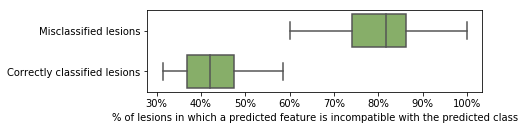

In [217]:
plt.figure(figsize=(6,1.5))
ax = sns.boxplot(x="value", y="metric", color='#86b95e', data=df)
#ax = sns.boxplot(x="feature", y="value", hue="metric", data=melt_df)
#ax.set(xlim=[.65,.9])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
ax.set(xlabel='% of lesions in which a predicted feature is incompatible with the predicted class', ylabel='');
ax.set_yticklabels(['Misclassified lesions', 'Correctly classified lesions']);
plt.savefig("/data/vision/polina/users/clintonw/incomp.png", dpi=800, bbox_inches="tight", pad_inches=0)

In [180]:
((A[:,-1])/(60-A[:,2])).mean()

0.46619134475116136

incompatible_accnums = []
for accnum, preds in predictions.items():
    feats, pred_cls = preds
    skip = False
    n = len(preds)
    for i in range(n-1):
        f = preds[i]
        for j in range(i+1,n):
            g = preds[j]
            if not np.any([f in features_by_cls[cls] and g in features_by_cls[cls] for cls in C.cls_names]):
                incompatible_accnums.append(accnum)
                skip = True
            if skip: break
        if skip: break

In [181]:
MISCLS[1]/

array([142., 258., 452., 375.])

In [ ]:
incompatible_accnums

In [155]:
len(incompatible_accnums) - 5

11

In [ ]:
miscls_accnums

In [167]:
set(miscls_accnums).difference(incompatible_accnums)

{'E100962970_0', 'E101415263_0'}

In [ ]:
exclusive_pairs

In [ ]:
features_by_cls

In [ ]:
predictions

In [144]:
keys = [key for key, _, _ in RET]

In [ ]:
predictions

In [ ]:
RET = df.loc[key][['feature_1', 'feature_2', 'feature_3', 'feature_4']].dropna().values

In [175]:
x = 0
for key, pred, true in RET:
    if len(set(pred).symmetric_difference(true)) == 0:
        x += 1

In [ ]:
for accnum in ["12569826_0", "E100121654_0", "E101415263_0", "12783467_0", "E102634440_0", "12961059_0"]:
    print(accnum, predictions[accnum][1], predictions[accnum][0])

### backup

In [15]:
model_num = 21
model_path = join(C.model_dir, "model_reader_new%d.hdf5" % model_num)

Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']
orig_data_dict, num_samples = cbuild._collect_unaug_data()

features_by_cls, feat_count = cnna.collect_features()
feat_count.pop("homogeneous texture")
#feat_count.pop("central scar")
all_features = sorted(list(feat_count.keys()))
cls_features = {f: [c for c in C.cls_names if f in features_by_cls[c]] for f in all_features}

Z_features = cnna.get_annotated_files(features_by_cls)
Z_features.pop("homogeneous texture")
#Z_features.pop("central scar")

num_features = len(all_features)

voi_df = drm.get_voi_dfs()[0]
M = keras.models.load_model(model_path)

M.layers[5].get_weights()[1]

In [16]:
def memory():
    pid = os.getpid()
    py = psutil.Process(pid)
    print('Memory use:', py.memory_info()[0]/2.**30)

In [31]:
model_num = 26
model_path = join(C.model_dir, "model_reader_new%d.hdf5" % model_num)
inf_xls_path = 'D:\\feature_analysis\\influence%d.xlsx' % model_num

df = pd.DataFrame(columns=["true_cls", "pred_cls"] + all_features)
#df = pd.read_excel(inf_xls_path, index_col=0)

In [18]:
Z_full = np.concatenate([orig_data_dict[cls][-1] for cls in C.cls_names],0)

all_imgs = []
all_cls = []

for lesion_id in Z_full:
    cls = voi_df.loc[lesion_id]["cls"]
    img = np.load(join(C.orig_dir, cls, lesion_id+".npy"))
    all_imgs.append(np.expand_dims(img,0))
    all_cls.append(C.cls_names.index(cls))

In [32]:
importlib.reload(finf)
del M, IA
K.clear_session()
M = keras.models.load_model(model_path)
IA = finf.InfluenceAnalyzer(M, voi_df, all_imgs, all_cls)

In [ ]:
t = time.time()
for lesion_id in Z_reader:
    cls = voi_df.loc[lesion_id]["cls"]
    img = np.load(join(C.orig_dir, cls, lesion_id+".npy"))
    img = np.expand_dims(img,0)
    pred_cls = M.predict(img)[0]
    pred_cls = C.cls_names[list(pred_cls).index(pred_cls.max())]
        
    print(lesion_id)
    
    g_test = IA.get_grad(lesion_id, pred_cls=pred_cls)
    s_test = IA.get_stest(g_test)

    del M, IA
    K.clear_session()
    M = keras.models.load_model(model_path)
    IA = finf.InfluenceAnalyzer(M, voi_df, all_imgs, all_cls)

    I = {}
    for f in Z_features:
        I[f] = IA.get_avg_influence(Z_features[f], s_test)

    del M, IA
    K.clear_session()
    M = keras.models.load_model(model_path)
    IA = finf.InfluenceAnalyzer(M, voi_df, all_imgs, all_cls)
    
    df.loc[lesion_id] = [cls, pred_cls] + list(I[f] for f in df.columns[2:])

    print(time.time() - t)
    memory()

In [36]:
inf_xls_path

'D:\\feature_analysis\\influence26.xlsx'

In [37]:
df.to_excel(inf_xls_path)

In [ ]:
cls = voi_df.loc[lesion_id]["cls"]
x_test = np.load(join(C.orig_dir, cls, lesion_id+".npy"))
vis.draw_slices(x_test)

Memory leak test
for _ in range(10):
    memory()
    g_test = IA.get_grad(lesion_id)
memory()

### extra

In [2]:
def perturb_weights(W_true, t):
    eps = 1e-5
    W = copy.deepcopy(W_true)
    t_ix = 0
    
    for w_ix in range(len(W)):
        W[w_ix] += eps * np.reshape(t[t_ix:t_ix+W[w_ix].size], W[w_ix].shape)
        t_ix += W[w_ix].size
        
    return W

In [3]:
def get_grad(lesion_id, perturb_W=None):
    C = config.Config()
    
    cls = voi_df.loc[lesion_id]["cls"]
    img = np.load(join(C.orig_dir, cls, lesion_id+".npy"))
    img = np.expand_dims(img,0)

    y_true = np_utils.to_categorical(C.cls_names.index(cls), 6)
    loss = K.categorical_crossentropy(y_true, M.output)
    
    with tf.device('/gpu:0'):
        g = K.gradients(loss, M.trainable_weights)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        g_i = sess.run(g, feed_dict={M.input:img, K.learning_phase():0})
        if perturb_W is not None:
            feed_dict_plus = {M.trainable_weights[i]:perturb_W[i] for i in range(len(perturb_W))}
            g_i_plus = sess.run(g, feed_dict={**feed_dict_plus, M.input:img, K.learning_phase():0})

    g_i = np.concatenate([x.flatten() for x in g_i], 0)
    
    if perturb_W is not None:
        g_i_plus = np.concatenate([x.flatten() for x in g_i_plus], 0)
        return g_i, g_i_plus
    
    return g_i

In [4]:
def get_grads(Z_sample):
    eps = 1e-5
    Ht = np.zeros(g_test.shape)
    feed_dict_plus = {M.trainable_weights[i]:perturb_W[i] for i in range(len(perturb_W))}
    losses = [K.categorical_crossentropy(y_true, M.output) for y_true in \
              [np_utils.to_categorical(i, 6) for i in range(6)]]
        
    t = time.time()
    with tf.device('/gpu:0'):
        g = [K.gradients(loss, M.trainable_weights) for loss in losses]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for ix in range(len(Z_sample)):
            g_i = sess.run(g[classes[ix]], feed_dict={M.input:imgs[ix], K.learning_phase():0})
            g_i = np.concatenate([x.flatten() for x in g_i], 0)
    if verbose:
        print(time.time()-t)
    
    return Ht / len(Z_sample)

In [24]:
def get_HVP(perturb_W, Z_sample, verbose=True):
    eps = 1e-5
    Ht = np.zeros(g_test.shape)
    feed_dict_plus = {M.trainable_weights[i]:perturb_W[i] for i in range(len(perturb_W))}
    losses = [K.categorical_crossentropy(y_true, M.output) for y_true in \
              [np_utils.to_categorical(i, 6) for i in range(6)]]
        
    t = time.time()
    with tf.device('/gpu:0'):
        g = [K.gradients(loss, M.trainable_weights) for loss in losses]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for ix in range(len(Z_sample)):
            g_i = sess.run(g[classes[ix]], feed_dict={M.input:imgs[ix], K.learning_phase():0})
            g_i_plus = sess.run(g[classes[ix]], feed_dict={**feed_dict_plus, M.input:imgs[ix], K.learning_phase():0})
    
            g_i = np.concatenate([x.flatten() for x in g_i], 0)
            g_i_plus = np.concatenate([x.flatten() for x in g_i_plus], 0)

            Ht += (g_i_plus - g_i)/eps
    if verbose:
        print(time.time()-t)
    
    return Ht / len(Z_sample)

In [23]:
t_k = np.zeros(g_test.shape)
r_k = g_test#-Ht
p_k = r_k

In [ ]:
num_iters = 15
#phi_hist = []
t = time.time()
for _ in range(num_iters):
    #Z_sample = random.sample(list(Z_full), 15)
    W_new = perturb_weights(W, p_k)
    Hp = get_HVP(W_new, Z_full)

    alpha = np.dot(r_k, r_k) / np.dot(p_k, Hp)
    t_k += alpha * p_k
    r_k2 = r_k - alpha * Hp
    #phi_hist = .5*np.dot(t_k, Ht) - g_test

    beta = np.dot(r_k2, r_k2) / np.dot(r_k, r_k)
    r_k = r_k2
    p_k = r_k + beta*p_k
print(time.time()-t)

In [33]:
del p_k

In [36]:
def get_grads(imgs, classes, s_test, verbose=True):
    eps = 1e-5
    Ht = np.zeros(g_test.shape)
    losses = [K.categorical_crossentropy(y_true, M.output) for y_true in \
              [np_utils.to_categorical(i, 6) for i in range(6)]]
        
    I = 0
    t = time.time()
    with tf.device('/gpu:0'):
        g = [K.gradients(loss, M.trainable_weights) for loss in losses]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for ix in range(len(classes)):
            g_i = sess.run(g[classes[ix]], feed_dict={M.input:imgs[ix], K.learning_phase():0})
            g_i = np.concatenate([x.flatten() for x in g_i], 0)
            I -= np.dot(g_i, s_test)
    if verbose:
        print(time.time()-t)
    
    return I / len(classes)

### others

In [47]:
df_0 = hf.pickle_load(join(C.base_dir, "data", "DFs4.bin"))[0]

In [41]:
data_dir = r"C:\Users\Clinton\Documents\voi-classifier\data"
answer_key = join(data_dir, "ground_truth.xlsx")
answer_key = pd.read_excel(answer_key, index_col=0)

In [46]:
answer_key.columns

Index(['true_cls', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'ignore_1', 'ignore_2', 'BLANK', 'Unnamed: 9', 'Class', 'Num features'],
      dtype='object')

In [53]:
for z_test, row in answer_key.iterrows():
    cls = df_0.loc[z_test, "pred_cls"]
    feats = row[[f for f in answer_key.columns if f.startswith('feat')]].dropna().values
    break

In [58]:
feats.dropna().values

array(['nodular growth', 'heterogeneous lesion',
       'progressive enhancement'], dtype=object)